# Deep Learning - Diplomatura en ciencias de datos
## UNC - FaMAF
## Práctico n°1 

__Integrantes:__
* Nindirí Armenta
* Leonardo Latini
* Juliana Benítez
* Florencia Alonso

__Consigna:__ Se trabajará con el conjuto de datos de petfinder. La tarea es predecir la velocidad de adopción de un conjunto de mascotas. Para ello, también se dispone de [esta competencia de Kaggle](https://www.kaggle.com/t/8842af91604944a9974bd6d5a3e097c5). Se trata de una tarea de __clasificación.__

_Más información del dataset:_

File descriptions

* train.csv - Tabular/text data for the training set
* test.csv - Tabular/text data for the test set
* sample_submission.csv - A sample submission file in the correct format
* breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
* color_labels.csv - Contains ColorName for each ColorID
* state_labels.csv - Contains StateName for each StateID

Data Fields

* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. 
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

AdoptionSpeed

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).


### Práctico 2 - Redes en escalera avanzadas

Este práctico es similar al práctico 1, pero agregará un paso extra que es el uso de redes en escalera avanzadas, ya sean Redes Convolucionales o Redes Recurrentes.

En este caso se usará la descripción como un feature extra y todo el procesamiento que ello requiere.


In [1]:
!pip install mlflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import nltk
import numpy as np
import os
import pandas as pd

from IPython.display import SVG
from gensim import corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint

nltk.download(["punkt", "stopwords"]);

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf


TensorFlow 2.x selected.


## Carga de los datos

In [0]:
DATA_DIRECTORY = '/content/drive/My Drive/DeepLearning/petfinder data'

In [6]:
dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'train.csv'))

target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]

dataset.head(3)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4


## Preproceso del texto para agregarlo como feature (manejo de secuencias)

A diferencia del práctico anterior, en este caso es necesario utilizar el texto como feature extra. Pueden luego agregarlo a una red recurrente o convolucional y concatenar su salida a los atributos "escalares" (como "raza" o "género").


### Tokenización

In [0]:
SW = set(stopwords.words("english"))

def tokenize_description(description):
    return [w.lower() for w in word_tokenize(description, language="english") if w.lower() not in SW]

# Fill the null values with the empty string to avoid errors with NLTK tokenization
dataset["TokenizedDescription"] = dataset["Description"].fillna(value="").apply(tokenize_description)

In [8]:
dataset.head(2)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID,TokenizedDescription
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0,"[nibble, 3+, month, old, ball, cuteness, ., en..."
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3,"[good, guard, dog, ,, alert, ,, active, ,, obe..."


#### Tamaño de las descripciones

Un punto importante a tener en cuenta es que las descripciones tienen tamaño variable, y esto no es compatible con los algoritmos de aprendizaje automático. Por lo que hay que llevar las secuencias a un tamaño uniforme.

Para definir dicho tamaño uniforme, es útil mirar qué tamaños mínimos, máximos y medios manejan las descripciones y a partir de esto establecer el tamaño máximo de la secuencia.

In [9]:
pprint(dataset["TokenizedDescription"].apply(len).describe())

count    10582.000000
mean        44.418541
std         48.464623
min          0.000000
25%         16.000000
50%         31.000000
75%         55.000000
max        803.000000
Name: TokenizedDescription, dtype: float64


Vemos que más del 75% de las secuencias tienen 55 palabras o menos. Esto es un buen punto de partida, así que podemos establecer el tamaño máximo de las secuencia en 55 palabras.

In [0]:
MAX_SEQUENCE_LEN = 55

## Vocabulario

In [0]:
vocabulary = corpora.Dictionary(dataset["TokenizedDescription"])
vocabulary.filter_extremes(no_below=1, no_above=1.0, keep_n=10000)
# me quedo con las 10000 palabras más frecuentes

## Word Embeddings (GloVe)

In [12]:
%%bash
mkdir -p dataset
# Descargar los word embeddings (GloVe)
curl -L -o ./dataset/glove.6B.zip https://cs.famaf.unc.edu.ar/~ccardellino/resources/diplodatos/glove.6B.zip
unzip ./dataset/glove.6B.zip glove.6B.100d.txt -d ./dataset

Archive:  ./dataset/glove.6B.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  822M  100  822M    0     0  15.0M      0  0:00:54  0:00:54 --:--:-- 15.6M
replace ./dataset/glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [13]:
embeddings_index = {}

with open("./dataset/glove.6B.100d.txt", "r") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        if word in vocabulary.token2id:  # Only use the embeddings of words in our vocabulary
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 7897 word vectors.


## Creación de los datasets

Similar al práctico anterior, tendremos datos que serán "one-hot-encoded", otros serán "embeddings" y otros serán numéricos.

El caso particular del texto es que será tratado como una secuencia de embeddings, y dichos embeddings no serán entrenados en conjunto con la red, sino que serán tomados de un modelo "pre-entrenado". En este caso utilizamos GloVe, pero podríamos haber utilizado otro modelo (e.g. FastText).

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Type', 'Gender', 'Color1', 'Vaccinated', 'MaturitySize', 'Sterilized', 'Health', 'FurLength']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1']
}
numeric_columns = ['Age', 'Fee']

## Generador del conjunto de datos

Dada la naturaleza de los datos de texto, y que estos representan una secuencia de datos (que se da luego a una red recurrente o convolucional), en este caso no crearemos los datasets de antemano, sino que los generaremos a medida que el algoritmo de entrenamiento los pida. 

En particular, es porque las secuencias de texto pueden no tener el mismo tamaño (las oraciones tienen diferente cantidad de palabras), pero para que los modelos de redes las acepten, necesitamos rellenarlas (*padding*) de manera que todas tengan el mismo tamaño.

En este paso también vamos a truncar aquellas secuencias de descripciones con más de `MAX_SEQUENCE_LEN` palabras, de manera que al hacer uso de `padded_batch` no lance un error al encontrarse con secuencias de tamaño mayor.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
norm = scaler.fit_transform(dataset[numeric_columns])
dfnorm = pd.DataFrame({'Age_norm':norm[:,0] ,'Fee_norm':norm[:,1]})
dataset = pd.concat([dfnorm, dataset], axis=1)
numeric_columns = ['Age_norm', 'Fee_norm']

In [16]:
def dataset_generator(ds, test_data=False):
    for _, row in ds.iterrows():
        instance = {}
        
        # One hot encoded features
        instance["direct_features"] = np.hstack([
            tf.keras.utils.to_categorical(row[one_hot_col] - 1, max_value)
            for one_hot_col, max_value in one_hot_columns.items()
        ])

        # Numeric features (should be normalized beforehand)
        for num_col in numeric_columns:
            instance[num_col] = [row[num_col]]
        
        # Embedded features
        for embedded_col in embedded_columns:
            instance[embedded_col] = [row[embedded_col]]
        
        # Document to indices for text data, truncated at MAX_SEQUENCE_LEN words
        instance["description"] = vocabulary.doc2idx(
            row["TokenizedDescription"],
            unknown_word_index=len(vocabulary)
        )[:MAX_SEQUENCE_LEN]
        
        # One hot encoded target for categorical crossentropy
        if not test_data:
            target = tf.keras.utils.to_categorical(row[target_col], nlabels)
            yield instance, target
        else:
            yield instance

# Set output types of the generator (for numeric types check the type is valid)
instance_types = {
    "direct_features": tf.float32,
    "description": tf.int32
}

for num_col in numeric_columns:
    instance_types[num_col] = tf.float32

for embedded_col in embedded_columns:
    instance_types[embedded_col] = tf.int32
        
tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(dataset),
    output_types=(instance_types, tf.int32)
)

for data, target in tf_dataset.take(2):
    pprint(data)
    pprint(target)
    print()

{'Age_norm': <tf.Tensor: id=41, shape=(1,), dtype=float32, numpy=array([-0.40931514], dtype=float32)>,
 'Breed1': <tf.Tensor: id=42, shape=(1,), dtype=int32, numpy=array([299], dtype=int32)>,
 'Fee_norm': <tf.Tensor: id=43, shape=(1,), dtype=float32, numpy=array([1.0101603], dtype=float32)>,
 'description': <tf.Tensor: id=44, shape=(42,), dtype=int32, numpy=
array([23,  2, 20, 24,  4, 10,  1, 11, 26,  1, 27,  9,  6, 21,  3,  8, 15,
       22, 33,  7, 13, 30,  1, 29, 18, 17,  1, 12, 31, 14,  5,  6, 16,  1,
       19, 28, 25, 32, 23,  0,  5,  1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=45, shape=(28,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.], dtype=float32)>}
<tf.Tensor: id=46, shape=(5,), dtype=int32, numpy=array([0, 0, 1, 0, 0], dtype=int32)>

{'Age_norm': <tf.Tensor: id=47, shape=(1,), dtype=float32, numpy=array([-0.3548879], dtype=float32)>,
 'Breed1': <tf.Tensor: id=

## Datos de entrenamiento y validación

Ya generado el conjunto de datos base, tenemos que dividirlo en entrenamiento y validación. Además, como vamos a utilizar algunos datos que forman secuencias, los lotes (*batches*) de datos deben estar "rellenados" (*padded_batch*). 

Si bien rellenaremos "todos" los atributos, en la práctica el único que efectivamente se rellenará es el de *description* pues es el único con tamaños distintos.

In [0]:
TRAIN_SIZE = int(dataset.shape[0] * 0.8)
DEV_SIZE = dataset.shape[0] - TRAIN_SIZE
BATCH_SIZE = 128

shuffled_dataset = tf_dataset.shuffle(TRAIN_SIZE + DEV_SIZE, seed=42)
# d.shuffle(shuffle_buffer_size)

# Pad the datasets to the max value for all the "non sequence" features
padding_shapes = (
    {k: [-1] for k in ["direct_features"] + numeric_columns + list(embedded_columns.keys())},
    [-1]
)

# Pad to MAX_SEQUENCE_LEN for sequence features
padding_shapes[0]["description"] = [MAX_SEQUENCE_LEN]

# Pad values are irrelevant for non padded data
padding_values = (
    {k: 0 for k in list(embedded_columns.keys())},
    0
)

# Padding value for direct features should be a float
padding_values[0]["direct_features"] = np.float32(0)

# Padding value for numeric features
for num_col in numeric_columns:
    padding_values[0][num_col] = np.float32(0)

# Padding value for sequential features is the vocabulary length + 1
padding_values[0]["description"] = len(vocabulary) + 1

train_dataset = shuffled_dataset.skip(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

dev_dataset = shuffled_dataset.take(DEV_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

## Construyendo el modelo

Al modelo anterior tenemos que agregarle la capa que maneje los embeddings de las palabras.

### Matriz de embeddings de palabras

In [0]:
EMBEDDINGS_DIM = 100  # Given by the model (in this case glove.6B.100d)

embedding_matrix = np.zeros((len(vocabulary) + 2, 100))

for widx, word in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[widx] = embedding_vector
    else:
        # Random normal initialization for words without embeddings
        embedding_matrix[widx] = np.random.normal(size=(100,))  

# Random normal initialization for unknown words
embedding_matrix[len(vocabulary)] = np.random.normal(size=(100,))

### Definiendo los inputs del modelo

Definamos los inputs del modelo, con el agregado de la capa de embeddings de palabras inicializada en `embedding_matrix`.

In [19]:
tf.keras.backend.clear_session()
from keras import regularizers

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = tf.keras.layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(
            tf.keras.layers.Embedding(
                input_dim=max_value, 
                output_dim=embedding_size
            )(input_layer), 
            axis=-2
        )
    )
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = tf.keras.layers.Input(
    shape=(sum(one_hot_columns.values()),), 
    name='direct_features'
)
inputs.append(direct_features_input)

# Numeric cols numeric_features
numeric_imputs = []
for num_col in numeric_columns:
    input_layer_num = tf.keras.layers.Input(shape=(1,), name=num_col)
    numeric_imputs.append(input_layer_num)
    inputs.append(input_layer_num)

# Word embedding layer para la descripción
description_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="description")
inputs.append(description_input)

word_embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding"
)(description_input)

Adding embedding of size 77 for layer Breed1


Using TensorFlow backend.


### Definiendo la red que trabajará con el texto

Antes de generar el *feature map* final entre los inputs y las clases, tenemos que generar el *feature map* de las secuencias de texto. Se puede utilizar una red neuronal recurrente o convolucional (recordemos que las redes se utilizan para hacer aprendizaje de representaciones).


In [0]:
# Create a CNN for the description input
FILTER_WIDTHS = [10, 15, 20]  # num of words
FILTER_COUNT = 20

conv_layers = [] 
for filter_width in FILTER_WIDTHS: 
    layer = tf.keras.layers.Conv1D(
        FILTER_COUNT, # the number of output filters in the convolution
        filter_width, # kernel_size
        activation="relu",
        name="conv_{}_words".format(filter_width)
    )(word_embeddings_layer)
    layer = tf.keras.layers.GlobalMaxPooling1D(name="max_pool_{}_words".format(filter_width))(layer)
    conv_layers.append(layer)

description_features = tf.keras.layers.Concatenate(name="convolved_features")(conv_layers)


### Definiendo el *feature map* final de la red

Ahora que tenemos nuestra representación de las descripciones, pasamos a combinarlo con los demás features en la última parte de nuestra red.

In [0]:
HIDDEN_LAYER_SIZE1 = 80
HIDDEN_LAYER_SIZE2 = 10

feature_map = tf.keras.layers.Concatenate(name="feature_map")(
    embedding_layers + [description_features, direct_features_input] + numeric_imputs
)

dense1 = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE1, activation="relu", kernel_initializer='RandomNormal', 
                    kernel_regularizer=regularizers.l2(0.001))(feature_map)
norm1 = tf.keras.layers.BatchNormalization(momentum=0)(dense1)
dropout1 = tf.keras.layers.Dropout(0.5)(norm1)
dense2 = tf.keras.layers.Dense(HIDDEN_LAYER_SIZE2, activation="relu", kernel_initializer='RandomNormal', 
                    kernel_regularizer=regularizers.l2(0.001))(dropout1)
norm2 = tf.keras.layers.BatchNormalization(momentum=0)(dense2)
dropout2 = tf.keras.layers.Dropout(0.5)(norm2)
output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(dropout2)

model = tf.keras.models.Model(inputs=inputs, outputs=[output_layer], name="amazing_model")

### Compilando y visualizando el modelo

In [22]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

Model: "amazing_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 55, 100)      1000200     description[0][0]                
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
conv_10_words (Conv1D)          (None, 46, 20)       20020       word_embedding[0][0]             
______________________________________________________________________________________

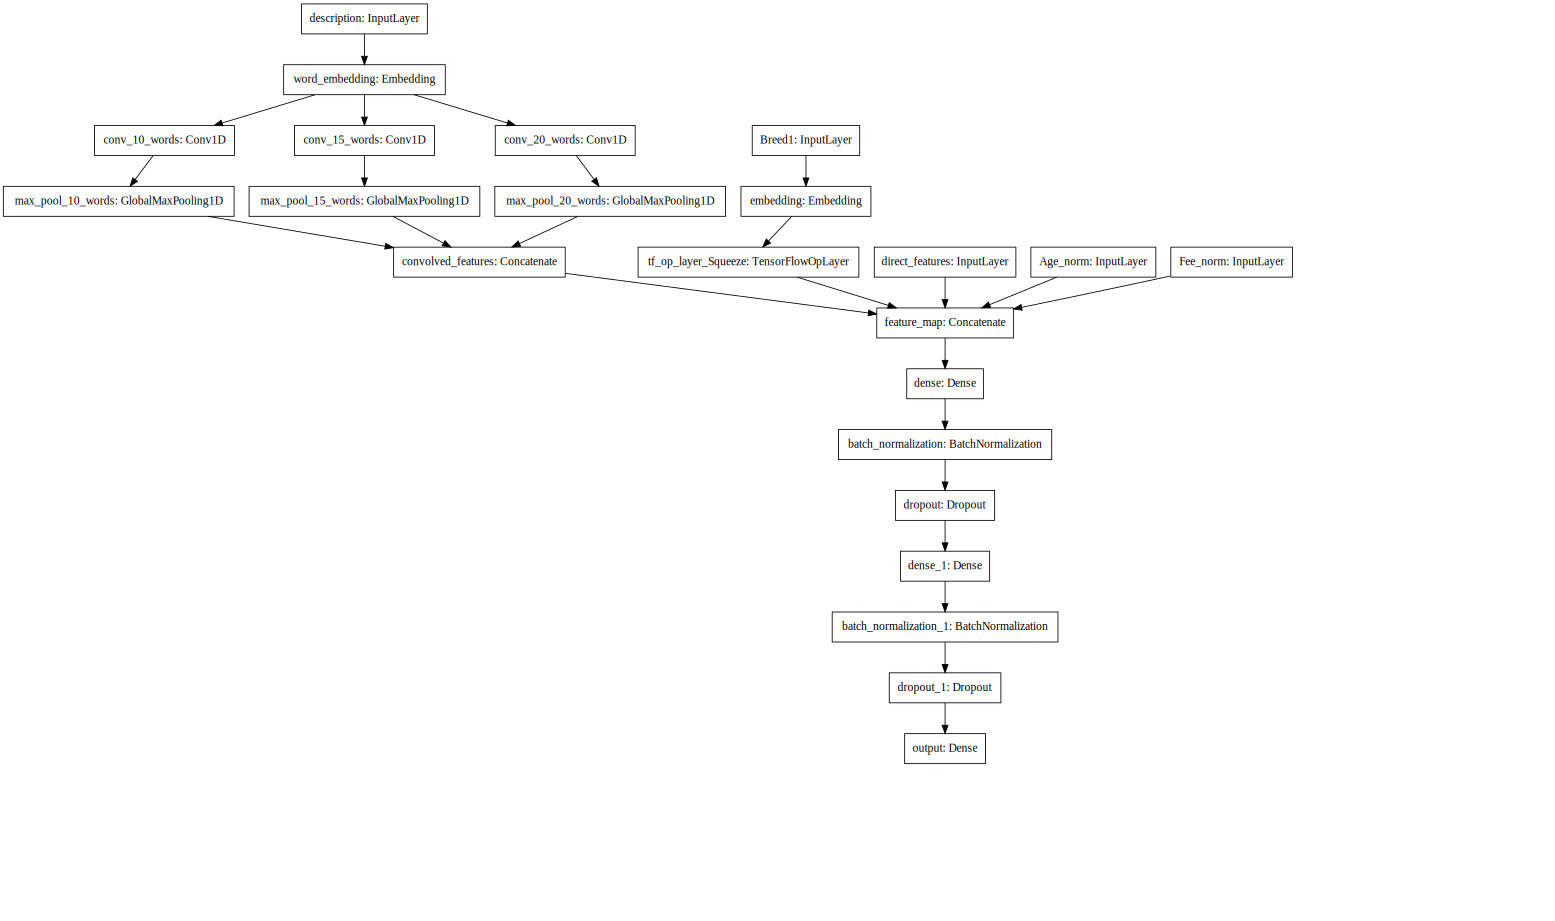

In [23]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

## Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente. Lo entrenamos con ayuda de `mlflow`.

In [24]:
import mlflow

mlflow.set_experiment('awesome_advanced_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('description_filter_widths', FILTER_WIDTHS)
    mlflow.log_param('description_filter_count', FILTER_COUNT)
    mlflow.log_param('hidden_layer_size1', HIDDEN_LAYER_SIZE1)
    mlflow.log_param('hidden_layer_size2', HIDDEN_LAYER_SIZE2)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns) 
    
    # Train
    epochs = 10
    history = model.fit(train_dataset, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose=0)
    print("\n*** Validation loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('train_loss', history.history["loss"][-1])
    mlflow.log_metric('train_accuracy', history.history["accuracy"][-1])
    mlflow.log_metric('validation_loss', loss)
    mlflow.log_metric('validation_accuracy', accuracy)

Epoch 1/10
67/67 [==============================] - 23s 347ms/step - loss: 2.1445 - accuracy: 0.2348
Epoch 2/10
67/67 [==============================] - 20s 296ms/step - loss: 1.8619 - accuracy: 0.2718
Epoch 3/10
67/67 [==============================] - 20s 296ms/step - loss: 1.7201 - accuracy: 0.2937
Epoch 4/10
67/67 [==============================] - 20s 293ms/step - loss: 1.6394 - accuracy: 0.3234
Epoch 5/10
67/67 [==============================] - 19s 287ms/step - loss: 1.5748 - accuracy: 0.3374
Epoch 6/10
67/67 [==============================] - 19s 286ms/step - loss: 1.5318 - accuracy: 0.3610
Epoch 7/10
67/67 [==============================] - 20s 296ms/step - loss: 1.4884 - accuracy: 0.3841
Epoch 8/10
67/67 [==============================] - 20s 301ms/step - loss: 1.4415 - accuracy: 0.4005
Epoch 9/10
67/67 [==============================] - 20s 292ms/step - loss: 1.4037 - accuracy: 0.4215
Epoch 10/10
67/67 [==============================] - 19s 287ms/step - loss: 1.3594 - accura

# CONCLUSIONES:

Se probaron varios hiperparámetros de la red para ver como afectaban al resultado final:

Los features map que se obtienen luego de concatenar todas las representaciones de la entrada son de 167 valores.
Se probaron dos capas densas, y para paliar el overfitting se usó el regularizador l2 y una capa dropout()
Además se usaron capas BatchNormalization.

Se observó que al usar una mayor probabilidad de dropout la red tarda más en aprender el conjunto de entrenamiento entre una época y la siguiente.

Filtros usados en la red cnn para crear la representación de las description de las mascotas.
* anchos de los filtros: se probó con  [5, 10, 15] y [10, 15, 20] optando por el segundo. Se evitó usar anchos muy pequeños en relación a la longitud de la sequencia en un intento por captar información más general de la description.
* cantidad de filtros por cada ancho: 20




==================================================================================================================

## Evaluando el modelo sobre los datos de evaluación para la competencia

Una vez que tenemos definido nuestro modelo, el último paso es ponerlo a prueba en los datos de evaluación para generar un archivo para enviar a la competencia Kaggle.

Comenzamos cargando el conjunto de datos.

In [25]:
test_dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'test.csv'))
test_dataset.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,PID
0,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,I just found it alone yesterday near my apartm...,1
1,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,Their pregnant mother was dumped by her irresp...,2
2,1,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,Siu Pak just give birth on 13/6/10 to 6puppies...,7
3,2,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,"Very manja and gentle stray cat found, we woul...",9
4,2,3,264,0,2,1,2,5,3,3,1,1,2,1,1,50,41326,Kali is a super playful kitten who is on the g...,11


## Creamos el conjunto de datos para darle al modelo entrenado

Tenemos que preprocesar los datos de evaluación de la misma manera que preprocesamos los de entrenamiento (para que sean compatibles con lo esperado por el modelo). Por suerte, es tan simple como hacer un par de modificaciones a lo ya hecho previamente. Lo único que tenemos que tener en cuenta es que ahora el conjunto de datos no generará una etiqueta.

In [26]:
# First tokenize the description

test_dataset["TokenizedDescription"] = test_dataset["Description"]\
    .fillna(value="").apply(tokenize_description)

# Normalización de features numéricos
scaler = StandardScaler()
numeric_columns = ['Age', 'Fee']
norm = scaler.fit_transform(test_dataset[numeric_columns])
dfnorm = pd.DataFrame({'Age_norm':norm[:,0] ,'Fee_norm':norm[:,1]})
test_dataset = pd.concat([dfnorm, test_dataset], axis=1)
numeric_columns = ['Age_norm', 'Fee_norm']

# Generate the basic TF dataset

tf_test_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(test_dataset, True),
    output_types=instance_types  # It should have the same instance types
)

for data in tf_test_dataset.take(2):  # The dataset only returns a data instance now (no target)
    pprint(data)
    print()

{'Age_norm': <tf.Tensor: id=5982, shape=(1,), dtype=float32, numpy=array([-0.52713054], dtype=float32)>,
 'Breed1': <tf.Tensor: id=5983, shape=(1,), dtype=int32, numpy=array([265], dtype=int32)>,
 'Fee_norm': <tf.Tensor: id=5984, shape=(1,), dtype=float32, numpy=array([-0.28477862], dtype=float32)>,
 'description': <tf.Tensor: id=5985, shape=(13,), dtype=int32, numpy=
array([ 116,  429, 1371,  991,  189,    1, 7873, 1043,   62,  600,  728,
          5,    1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=5986, shape=(28,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.], dtype=float32)>}

{'Age_norm': <tf.Tensor: id=5987, shape=(1,), dtype=float32, numpy=array([-0.52713054], dtype=float32)>,
 'Breed1': <tf.Tensor: id=5988, shape=(1,), dtype=int32, numpy=array([307], dtype=int32)>,
 'Fee_norm': <tf.Tensor: id=5989, shape=(1,), dtype=float32, numpy=array([-0.28477862], dtype=float32)>,

## Padding batches

Por último, y previo a probar el modelo sobre los datos de evaluación, generamos el conjunto de datos "rellenado". 

A diferencia de los datos de entrenamiento y validación, en este caso no permutamos las instancias, pues necesitamos saber a que `PID` pertenece cada una.

Por otra parte, utilizamos los mismos valores de `padding_shapes` y `padding_values` para el primer componente (el de los datos), ignorando el valor del segundo componente (el de las etiquetas).

In [0]:
test_data = tf_test_dataset.padded_batch(
    BATCH_SIZE, 
    padded_shapes=padding_shapes[0], 
    padding_values=padding_values[0]
)

## Correr el modelo

El último paso es correr el modelo sobre los datos de evaluación para conseguir las predicciones a enviar a la competencia.

In [0]:
test_dataset["AdoptionSpeed"] = model.predict(test_data).argmax(axis=1)

test_dataset.to_csv("./submission.csv", index=False, columns=["PID", "AdoptionSpeed"])